In [64]:
!pip install kaggle --quiet

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python -p ./data
!unzip -o ./data/customer-segmentation-tutorial-in-python.zip -d ./data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python
License(s): other
customer-segmentation-tutorial-in-python.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./data/customer-segmentation-tutorial-in-python.zip
  inflating: ./data/Mall_Customers.csv  


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid", font_scale=1.1)


df = pd.read_csv("./data/Mall_Customers.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [66]:
print(df.info())
display(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


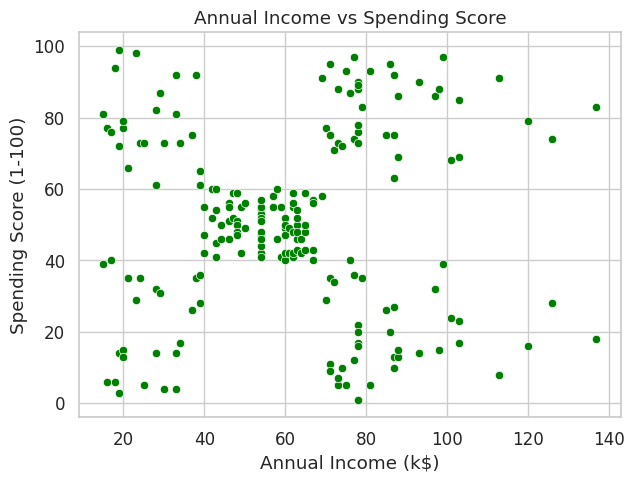

In [67]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)", data=df, color="green")
plt.title("Annual Income vs Spending Score")
plt.show()

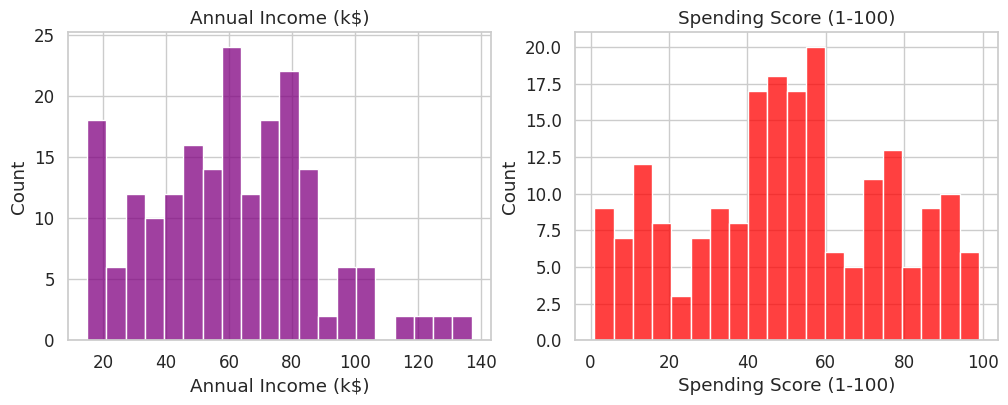

In [68]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

sns.histplot(df["Annual Income (k$)"], bins=20, ax=axes[0], color="purple")
axes[0].set_title("Annual Income (k$)")
sns.histplot(df["Spending Score (1-100)"], bins=20, ax=axes[1], color="red")
axes[1].set_title("Spending Score (1-100)")
plt.show()

In [69]:
features = ["Annual Income (k$)", "Spending Score (1-100)"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()


,Annual Income (k$),Spending Score (1-100)
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


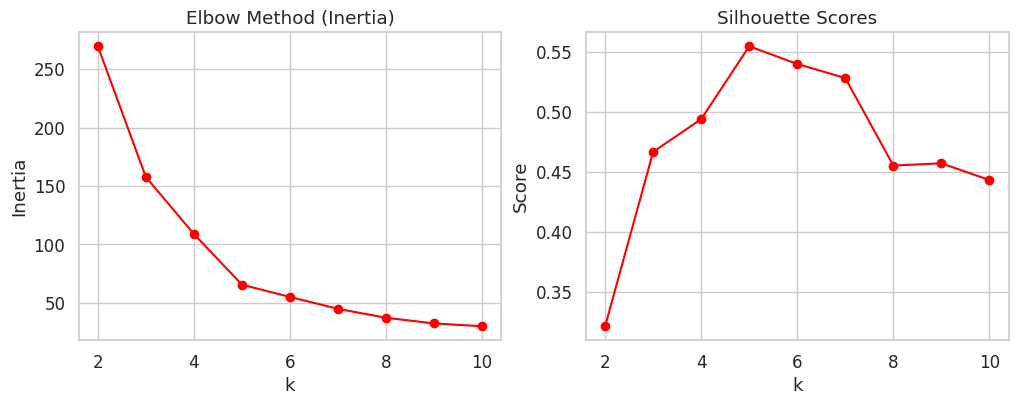

In [70]:
inertias, sil_scores = [], []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled_df)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled_df, labels))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(K_range, inertias, "-o", color= "red")
plt.title("Elbow Method (Inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, "-o", color= "red")
plt.title("Silhouette Scores")
plt.xlabel("k"); plt.ylabel("Score")

plt.show()


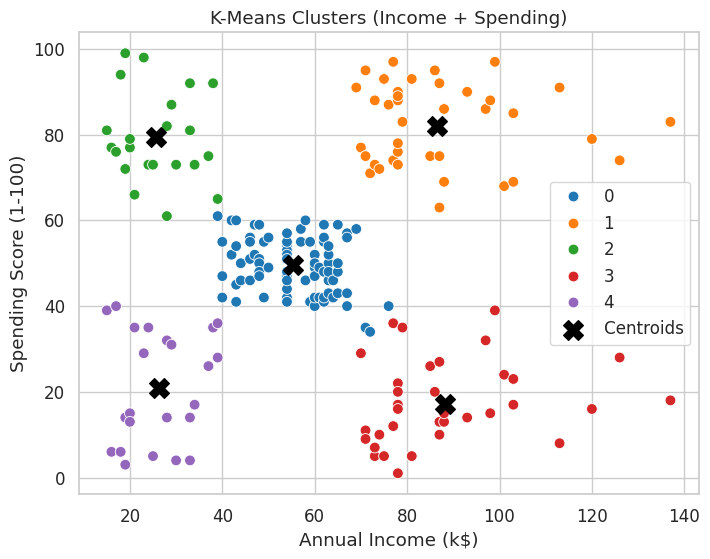

In [71]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled_df)

df["Cluster_KMeans"] = labels

centroids_orig = scaler.inverse_transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
palette = sns.color_palette("tab10", n_colors=k)
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)",
                hue="Cluster_KMeans", data=df, palette=palette, s=60)
plt.scatter(centroids_orig[:,0], centroids_orig[:,1], marker="X", s=200, c="black", label="Centroids")
plt.title(f"K-Means Clusters (Income + Spending)")
plt.legend()
plt.show()


In [72]:
cluster_summary = df.groupby("Cluster_KMeans")[features].mean().round(2)
cluster_counts = df["Cluster_KMeans"].value_counts().sort_index()

print("Cluster sizes:\n", cluster_counts)
print("\nCluster averages:\n")
display(cluster_summary)



Cluster sizes:
 Cluster_KMeans
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64

Cluster averages:



,Annual Income (k$),Spending Score (1-100)
Cluster_KMeans,,
0,55.30,49.52
1,86.54,82.13
2,25.73,79.36
3,88.20,17.11
4,26.30,20.91


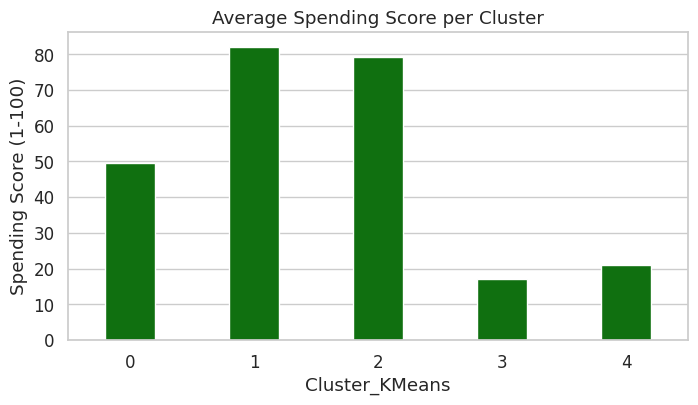

In [73]:
plt.figure(figsize=(8,4))
sns.barplot(x=cluster_summary.index, y="Spending Score (1-100)", data=cluster_summary.reset_index(), color= "green" , width =0.4)
plt.title("Average Spending Score per Cluster")
plt.show()


DBSCAN clusters: {np.int64(0), np.int64(-1)}
Cluster_DBSCAN
 0    195
-1      5
Name: count, dtype: int64


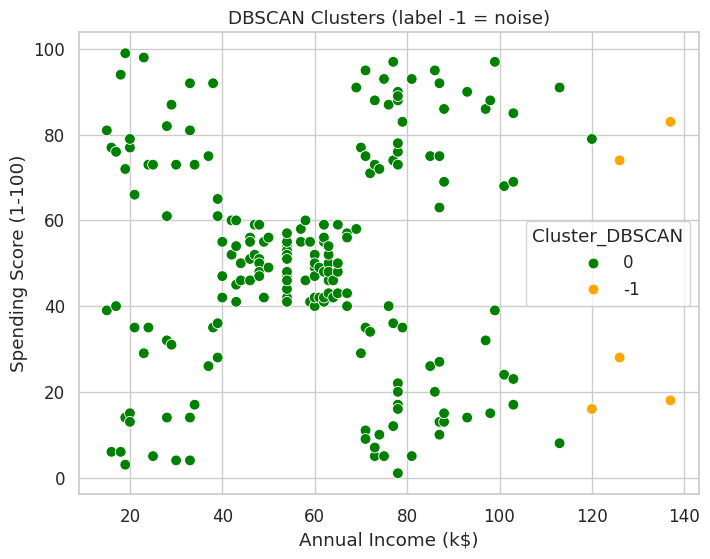

In [74]:
dbscan = DBSCAN(eps=0.6, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled_df)
df["Cluster_DBSCAN"] = db_labels

print("DBSCAN clusters:", set(db_labels))
print(df["Cluster_DBSCAN"].value_counts())

plt.figure(figsize=(8,6))
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)",
                hue=df["Cluster_DBSCAN"].astype(str), data=df, palette=["green", "orange"], s=60)
plt.title("DBSCAN Clusters (label -1 = noise)")
plt.show()


In [75]:
df.to_csv("Mall_Customers_with_clusters.csv", index=False)
print("Saved results with cluster labels → Mall_Customers_with_clusters.csv")


Saved results with cluster labels → Mall_Customers_with_clusters.csv
